In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# TAB device  (community)
# unit_id = f884bf8c-e6d1-431c-b449-a2a6e0da44c6 
# start utc = 2024-10-27T08:30:00.000Z
# end utc = 2024-10-27T09:00:00.000

# Elfi QA  
# unit_id = 7536f0b1-2510-4f94-a9b6-38390da72cd8 
# start utc = 2025-05-27T12:18:00Z
# end utc = 2025-05-27T14:30:00Z

### API request and data transformations

In [3]:
def save_response(page_num, response, logger:str):
    file_name = f"{logger.replace('.','_')}_{page_num}.json" 
    file_path = '../es_data/vehicle_data/'+file_name
    with open(file_path, 'w') as json_response:
        json_response.write(response.text)
    return file_path

In [22]:
import requests
from datetime import datetime
import os

token_path = "../csv_data/secrets/qa_autopi_token.txt"
with open(token_path, "r") as file:
    content = file.read().strip()  # .strip() removes any trailing newlines or spaces

# Set the environment variable
os.environ["MY_TOKEN"] = content

req_url = "https://api.cloud01.qa.autopi.io/logbook/raw/"

headers_list = {
 "Accept": "*/*",
 "Content-Type": "application/json",
 "Authorization": f"APIToken {os.environ.get('MY_TOKEN')}" 
}

start = "2025-05-28T13:00:31Z"
end   = "2025-05-28T17:00:00Z"
loggers = ["obd.rpm", "obd.speed", "obd.engine_load"] #"obd.oem_hv_battery_voltage"
json_files = []

for logger in loggers: 
    one_day_params = {"device_id":"7536f0b1-2510-4f94-a9b6-38390da72cd8",
            "page_num":0,
            "page_size":1000, 
            "data_type": logger,
            "start_utc": start,
            "end_utc": end,
            "upload_time": False }

    response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
    new_file = save_response(0, response, logger)
    
    json_files.append(new_file)
    total_records = response.json()['count']
    print(f"Found {total_records} data points from {start} to {end}")
    total_pages = round(total_records / 1000) 

    page_num = 0
    while page_num < total_pages: # request next pages
        page_num += 1
        one_day_params["page_num"] = page_num
        response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
        new_file = save_response(page_num, response, logger)
        json_files.append(new_file)
        

Found 64 data points from 2025-05-28T13:00:31Z to 2025-05-28T17:00:00Z
Found 64 data points from 2025-05-28T13:00:31Z to 2025-05-28T17:00:00Z
Found 64 data points from 2025-05-28T13:00:31Z to 2025-05-28T17:00:00Z


In [7]:
response

<Response [400]>

In [4]:
json_files

['../es_data/vehicle_data/obd_rpm_0.json',
 '../es_data/vehicle_data/obd_rpm_1.json',
 '../es_data/vehicle_data/obd_rpm_2.json',
 '../es_data/vehicle_data/obd_rpm_3.json',
 '../es_data/vehicle_data/obd_rpm_4.json',
 '../es_data/vehicle_data/obd_rpm_5.json',
 '../es_data/vehicle_data/obd_rpm_6.json',
 '../es_data/vehicle_data/obd_rpm_7.json']

In [62]:
combined_df.sort_values('ts', ascending=True)

,rec,ts,t,value
2256,2024-10-29T13:34:59.876457Z,2024-10-29T13:34:26.010000Z,obd.oem_hv_battery_voltage,364.8
2255,2024-10-29T13:35:01.821561Z,2024-10-29T13:34:28.010000Z,obd.oem_hv_battery_voltage,364.9
2254,2024-10-29T13:35:03.257910Z,2024-10-29T13:34:33.010000Z,obd.oem_hv_battery_voltage,365.0
2253,2024-10-29T13:35:04.219290Z,2024-10-29T13:34:35.010000Z,obd.oem_hv_battery_voltage,363.5
2252,2024-10-29T13:35:04.931698Z,2024-10-29T13:34:38.010000Z,obd.oem_hv_battery_voltage,363.4
...,...,...,...,...
4,2024-10-30T12:44:58.316774Z,2024-10-30T12:44:54.020000Z,obd.oem_hv_battery_voltage,389.5
3,2024-10-30T12:44:59.030501Z,2024-10-30T12:44:57.010000Z,obd.oem_hv_battery_voltage,389.7
2,2024-10-30T12:45:07.852653Z,2024-10-30T12:45:05.010000Z,obd.oem_hv_battery_voltage,389.8
1,2024-10-30T12:45:10.510903Z,2024-10-30T12:45:07.010000Z,obd.oem_hv_battery_voltage,389.7


### EDA

In [ ]:
df = pd.read_csv('customer_data/combined_responses.csv')

In [26]:
df.drop(['Unnamed: 0'], axis=1)

,rec,ts,t,value
0,2024-10-29T13:34:59.876457Z,2024-10-29 13:34:26.010000+00:00,obd.oem_hv_battery_voltage,364.8
1,2024-10-29T13:35:01.821561Z,2024-10-29 13:34:28.010000+00:00,obd.oem_hv_battery_voltage,364.9
2,2024-10-29T13:35:03.257910Z,2024-10-29 13:34:33.010000+00:00,obd.oem_hv_battery_voltage,365.0
3,2024-10-29T13:35:04.219290Z,2024-10-29 13:34:35.010000+00:00,obd.oem_hv_battery_voltage,363.5
4,2024-10-29T13:35:04.931698Z,2024-10-29 13:34:38.010000+00:00,obd.oem_hv_battery_voltage,363.4
...,...,...,...,...
2252,2024-10-30T12:44:58.316774Z,2024-10-30 12:44:54.020000+00:00,obd.oem_hv_battery_voltage,389.5
2253,2024-10-30T12:44:59.030501Z,2024-10-30 12:44:57.010000+00:00,obd.oem_hv_battery_voltage,389.7
2254,2024-10-30T12:45:07.852653Z,2024-10-30 12:45:05.010000+00:00,obd.oem_hv_battery_voltage,389.8
2255,2024-10-30T12:45:10.510903Z,2024-10-30 12:45:07.010000+00:00,obd.oem_hv_battery_voltage,389.7


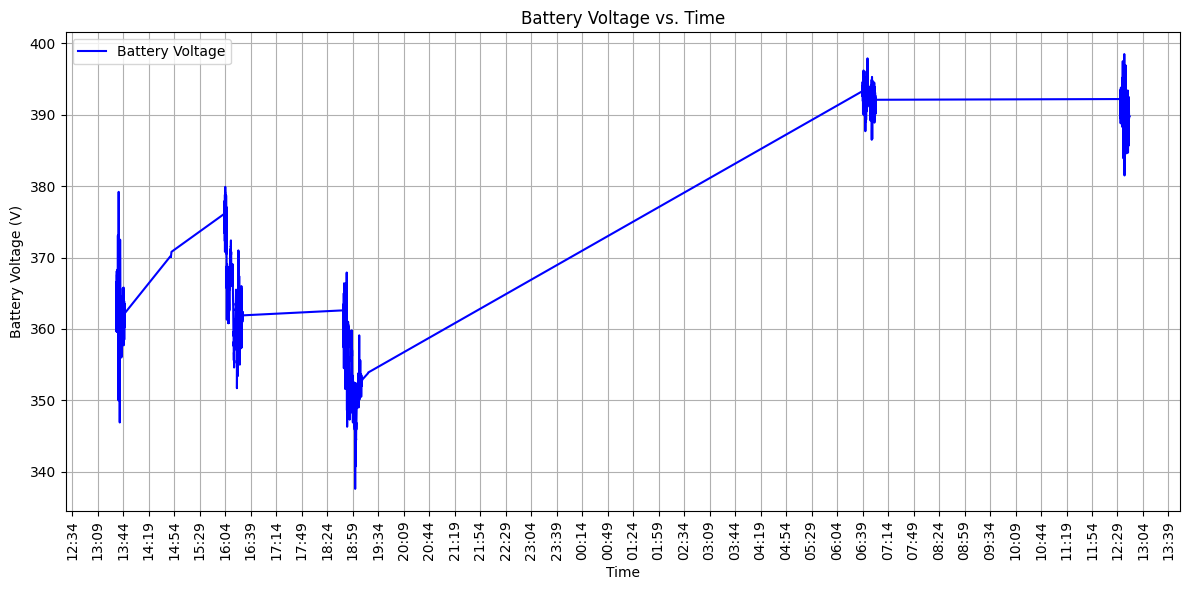

In [ ]:
# # Convert the 'ts' column to datetime
# df['ts'] = pd.to_datetime(df['ts'])

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(df['ts'], df['value'], label="Battery Voltage", color='blue')

# # Set x-axis to display time labels every 15 minutes without the year
# plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=35))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Rotate x labels for clarity
# plt.xlabel('Time')
# plt.xticks(rotation=90)

# # Y-axis and other plot elements
# plt.ylabel('Battery Voltage (V)')
# plt.title('Battery Voltage vs. Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()